# Libraries
---

In [1]:
import os
import pickle
import gc # Garbage collection for MPS
import numpy as np
import pandas as pd
from collections import defaultdict
from time import time
import random
# Pytorch libraries (Machine Learning)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
from sklearn.model_selection import train_test_split
# CWT libraries
import pywt
from tqdm import tqdm
# PSD libraries
from scipy.signal import welch
# Visualization Libraries
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
# TensorFlow Libraries
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History

DATAFILES_DIR = '../Datafiles'
MODELFILES_DIR = '../Models'
UCIHARFILES_DIR = '../UCI_HAR'
COLLECTIONFILES_DIR = '../data-collections'

In [12]:
MODELFILES_DIR = '../Models'
UCIHARFILES_DIR = '../UCI_HAR'

# Continuous Wavelet Transformation/Power Spectral Density

We will import the files into a DataFrame and then use them to process continuous wavelet sonographs and Power Spectral Density to capture better tremor and tonic movements, which represent each feature as a channel, allowing us to use Convolutional Neural Networks (CNN) with pure image feature extraction algorithms. This way, we can get a better level of efficiency, but we need to compare this against data outside of our dataset, which lacks the additional two channels that we are getting from the ultrasonics

In [ ]:
# CWT parameters
scales = range(1, 128)
waveletname = 'morl'

# Device setup (prefer MPS if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

def normalize_signal(data):
    return (data - data.mean(axis=0)) / (data.std(axis=0) + 1e-6)

def extract_tensor_from_csv_with_index(csv_path, target_len=127):
    df = pd.read_csv(csv_path)
    cols = ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 
            'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']
    data = df[cols].values
    data = normalize_signal(data)

    if len(data) >= target_len:
        start_index = (len(data) - target_len) // 2
        data = data[start_index:start_index + target_len, :]
    else:
        start_index = 0
        pad_width = target_len - len(data)
        pad = np.zeros((pad_width, data.shape[1]), dtype=np.float32)
        data = np.vstack([data, pad])

    return data.astype(np.float32), start_index

def load_batch_with_tracking(paths, is_train=True):
    all_data = []
    segment_list = train_segments if is_train else test_segments
    for i, p in enumerate(paths):
        data, idx = extract_tensor_from_csv_with_index(p)
        all_data.append(data)
        segment_list.append({"file": p, "start_index": idx, "tensor_index": len(all_data)-1})
    return np.stack(all_data)

def compute_cwt(signal_1d):
    coeff, _ = pywt.cwt(signal_1d.cpu().numpy(), scales, waveletname, 1)
    return torch.from_numpy(coeff[:, :127]).float().to(device)

def process_dataset_tensor(data, batch_size=32):
    num_samples, signal_length, num_channels = data.shape
    result = torch.zeros((num_samples, 127, 127, num_channels), device=device)

    for ch in range(num_channels):
        print(f"Processing channel {ch+1}/{num_channels}")
        for i in tqdm(range(0, num_samples, batch_size)):
            batch = data[i:i+batch_size, :, ch]
            batch_tensor = torch.from_numpy(batch).float().to(device)
            for k in range(batch_tensor.shape[0]):
                result[i + k, :, :, ch] = compute_cwt(batch_tensor[k])
    return result.cpu().numpy()

def compute_psd_for_signal(signal_1d, fs=50, nperseg=64):
    freqs, psd = welch(signal_1d, fs=fs, nperseg=nperseg)
    return psd

def process_psd_dataset(data):
    num_samples, _, num_channels = data.shape
    example_psd = compute_psd_for_signal(data[0, :, 0])
    psd_length = len(example_psd)
    psd_dataset = np.zeros((num_samples, psd_length, num_channels), dtype=np.float32)

    print("Processing PSD for each sample and channel...")
    for i in tqdm(range(num_samples)):
        for ch in range(num_channels):
            signal = data[i, :, ch]
            psd = compute_psd_for_signal(signal)
            psd_dataset[i, :, ch] = psd

    return psd_dataset

def load_and_split_dataset(root_dir, train_ratio=0.8, seed=42):
    samples = []
    labels = []
    label_to_index = {}
    file_paths = []

    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".csv") or file.endswith(".CSV"):
                path = os.path.join(root, file)
                path_parts = os.path.normpath(root).split(os.sep)

                if len(path_parts) < 2:
                    continue

                if path_parts[-1].lower() == "variants":
                    if len(path_parts) < 3:
                        continue
                    classifier, behavior = path_parts[-3], path_parts[-2]
                elif len(path_parts) >= 2 and path_parts[-2].lower() == "variants":
                    if len(path_parts) < 4:
                        continue
                    classifier, behavior = path_parts[-4], path_parts[-3]
                else:
                    classifier, behavior = path_parts[-2], path_parts[-1]

                label = f"{classifier}_{behavior}"
                if label not in label_to_index:
                    label_to_index[label] = len(label_to_index)
                file_paths.append((path, label_to_index[label]))

    paths, labels = zip(*file_paths)
    paths = np.array(paths)
    labels = np.array(labels)

    import json
    with open(f"{DATAFILES_DIR}/label_index_map.json", "w") as f:
        json.dump(label_to_index, f, indent=4)
    print("Label-to-index mapping saved to label_index_map.json")

    print(f'This is the number of CSV files detected: {len(paths)}')
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        paths, labels, train_size=train_ratio, random_state=seed, stratify=labels
    )

    print("Loading training data...")
    train_data = load_batch_with_tracking(train_paths, is_train=True)
    print("Loading test data...")
    test_data = load_batch_with_tracking(test_paths, is_train=False)

    with open(f"{DATAFILES_DIR}/raw_handgestures_filepaths_segments.pkl", 'wb') as f:
        pickle.dump({
            "train_segments": train_segments,
            "test_segments": test_segments
        }, f)
    print("Raw file paths saved to raw_handgestures_filepaths_segments.pkl")

    return train_data, train_labels, test_data, test_labels, label_to_index

full_dataset_root = COLLECTIONFILES_DIR

train_segments = []
test_segments = []

train_data, train_labels, test_data, test_labels, label_dict = load_and_split_dataset(full_dataset_root)

raw_dataset = {
    "train_data": torch.tensor(train_data),
    "train_labels": torch.tensor(train_labels),
    "test_data": torch.tensor(test_data),
    "test_labels": torch.tensor(test_labels),
    "label_dict": label_dict,
    "train_segments": train_segments,
    "test_segments": test_segments
}
torch.save(raw_dataset, f"{DATAFILES_DIR}/raw_handgestures_6channels_dataset.pt")
print("Raw dataset saved to raw_handgestures_6channels_dataset.pt")

psd_train = process_psd_dataset(train_data)
psd_test = process_psd_dataset(test_data)

torch.save({
    "psd_train": torch.tensor(psd_train),
    "train_labels": torch.tensor(train_labels),
    "psd_test": torch.tensor(psd_test),
    "test_labels": torch.tensor(test_labels),
    "label_dict": label_dict
}, f"{DATAFILES_DIR}/psd_handgestures_6channels_dataset.pt")
print("PSD dataset saved to psd_handgestures_6channels_dataset.pt")

print("\nProcessing CWT for training data...")
x_train = process_dataset_tensor(train_data)
y_train = train_labels[:len(x_train)]

print("\nProcessing CWT for test data...")
x_test = process_dataset_tensor(test_data)
y_test = test_labels[:len(x_test)]

print("\nCWT Processing complete. Saving data state for 6 channels...")
torch.save({
    "x_train": torch.tensor(x_train),
    "y_train": torch.tensor(y_train),
    "x_test": torch.tensor(x_test),
    "y_test": torch.tensor(y_test),
    "label_dict": label_dict
}, f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt")

print(f"\nx_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


Using device: mps
Label-to-index mapping saved to label_index_map.json
This is the number of CSV files detected: 26979
Loading training data...
Loading test data...
Raw file paths saved to raw_handgestures_filepaths_segments.pkl
Raw dataset saved to raw_handgestures_6channels_dataset.pt
Processing PSD for each sample and channel...


100%|███████████████████████████████████| 21583/21583 [00:07<00:00, 3018.89it/s]


Processing PSD for each sample and channel...


100%|█████████████████████████████████████| 5396/5396 [00:01<00:00, 2869.44it/s]


PSD dataset saved to psd_handgestures_6channels_dataset.pt

Processing CWT for training data...
Processing channel 1/6


100%|█████████████████████████████████████████| 675/675 [01:41<00:00,  6.65it/s]


Processing channel 2/6


100%|█████████████████████████████████████████| 675/675 [01:15<00:00,  8.89it/s]


Processing channel 3/6


100%|█████████████████████████████████████████| 675/675 [01:16<00:00,  8.87it/s]


Processing channel 4/6


 99%|████████████████████████████████████████▌| 667/675 [01:15<00:00,  8.99it/s]

In [2]:
# Load the saved dictionary
data = torch.load(f"{DATAFILES_DIR}/cwt_handgestures_6channels_dataset.pt", map_location="cpu")  # or 'device' if using GPU/MPS

# Unpack the contents into variables
x_train = data["x_train"]
y_train = data["y_train"]
x_test = data["x_test"]
y_test = data["y_test"]
label_dict = data["label_dict"]

In [3]:
# Load the dataset
data = torch.load(f"{DATAFILES_DIR}/psd_handgestures_6channels_dataset.pt")

# Extract variables
psd_train = data["psd_train"]
train_labels = data["train_labels"]
psd_test = data["psd_test"]
test_labels = data["test_labels"]
label_dict = data["label_dict"]

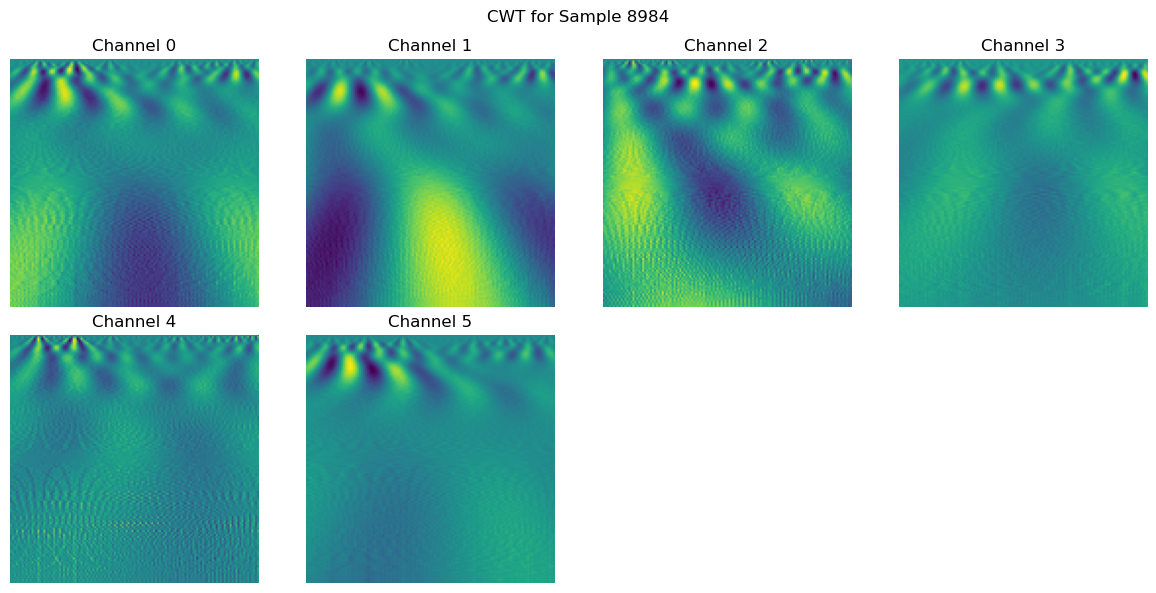

In [5]:
# Choose a random sample index
sample_index = random.randint(0, x_train.shape[0] - 1)

# Plot the CWT images for all channels in that sample
plt.figure(figsize=(12, 6))
for ch in range(x_train.shape[3]):  # Automatically use available channels
    plt.subplot(2, 4, ch + 1)
    plt.imshow(x_train[sample_index, :, :, ch], cmap='viridis')
    plt.title(f'Channel {ch}')
    plt.axis('off')
plt.suptitle(f'CWT for Sample {sample_index}')
plt.tight_layout()
plt.show()

# Machine Learning

This will use Pytorch to do training on the dataset pre-processed into sonographs. This is memory-optimized to ensure that MPS does
not have problems with memory leaking, and ensure that we can maintain a large enough batch size.

If MPS is possible, then that device feature will be used. This will offload much of the training to the graphics cores, but some of
The main processor will still be used for training, especially in the beginning. This is a memory-intensive task, and expect the memory pressure at first to be near 50GB, but it does reduce down to approximately 20GB after dataloading. This will be intensive on any machine that does not have 32GB of memory.

This training will run for ten epochs, to ensure that we can reach a high enough accuracy with the test dataset (validation data)

## Save Model

Save the trained model for later use

## Inspect Size and Shape

We will inspect the size and shape of the data and tensors, so that we can determine what kind of samples we have to train

In [21]:
print("x_train shape:", x_train.shape)
print("x_train_tensor shape:", x_train_tensor.shape)
print("x_train_tensor stats: mean =", x_train_tensor.mean().item(), "std =", x_train_tensor.std().item())
print("Sample input min/max:", x_train_tensor[0].min().item(), x_train_tensor[0].max().item())

x_train shape: torch.Size([15420, 127, 127, 8])
x_train_tensor shape: torch.Size([15420, 8, 127, 127])
x_train_tensor stats: mean = 1.1779571242043207e-11 std = 0.9998869299888611
Sample input min/max: -5.922956943511963 5.4239912033081055


# Validations
---

## Convert CWTs for UCI HAR

We need to convert the wavelet sonographs into 6 channels instead of 8 channels

In [3]:
# New version of ML Model with CNN based on CWT Sonograms, and LSTM for temporal analysis

# Memory Configuration (must come first)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

# Memory monitoring function
def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# Device and seed setup
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# Parameters
input_shape = (127, 127, 6)
batch_size = 16
num_classes = len(label_dict)
epochs = 10
accumulation_steps = 2
time_steps = 8  # number of temporal slices per sample

# Assume x_train, x_test, y_train, y_test are defined elsewhere
# For example, x_train shape: (N, 127, 127, 6)
# y_train shape: (N,)
# Make sure data is torch tensor or numpy array accordingly

# Mapping labels to indices
y_all = np.concatenate([y_train, y_test])
index_to_label = {label: idx for idx, label in enumerate(sorted(set(y_all)))}
y_train_indices = np.array([index_to_label[label.item()] if hasattr(label, 'item') else index_to_label[label] for label in y_train])
y_test_indices = np.array([index_to_label[label.item()] if hasattr(label, 'item') else index_to_label[label] for label in y_test])

def normalize(tensor):
    mean = tensor.mean(dim=(2, 3), keepdim=True)
    std = tensor.std(dim=(2, 3), keepdim=True) + 1e-6
    return (tensor - mean) / std

# x_train_tensor = normalize(torch.tensor(x_train).float().permute(0, 3, 1, 2))  # (N, C, H, W)
# x_test_tensor = normalize(torch.tensor(x_test).float().permute(0, 3, 1, 2))
x_train_tensor = normalize(x_train.detach().clone().float().permute(0, 3, 1, 2))
x_test_tensor = normalize(x_test.detach().clone().float().permute(0, 3, 1, 2))
y_train_tensor = torch.tensor(y_train_indices, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_indices, dtype=torch.long)

def pad_to_multiple(tensor, multiple, dim=0, pad_value=0):
    """
    Pads tensor along dimension `dim` to a size that is a multiple of `multiple`.
    """
    size = tensor.size(dim)
    remainder = size % multiple
    if remainder == 0:
        return tensor  # no padding needed
    padding_size = multiple - remainder
    pad_shape = list(tensor.shape)
    pad_shape[dim] = padding_size
    pad_tensor = torch.full(pad_shape, pad_value, dtype=tensor.dtype, device=tensor.device)
    return torch.cat([tensor, pad_tensor], dim=dim)

# Pad datasets so total samples are divisible by time_steps
x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)  # Use ignore_index -100 for padding labels
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)

# Reshape to (batch, time_steps, channels, H, W)
num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

x_train_seq = x_train_tensor.view(num_train_batches, time_steps, *input_shape[::-1])  # input_shape[::-1] flips (H,W,C) -> (C,H,W)
y_train_seq = y_train_tensor.view(num_train_batches, time_steps)

x_test_seq = x_test_tensor.view(num_test_batches, time_steps, *input_shape[::-1])
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

# We only use the label of the last timestep for training/classification
y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]

# Model definition
class CNNLSTM(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNNLSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 63x63

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 31x31

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 15x15
        )
        # Infer CNN output size dynamically
        dummy_input = torch.zeros(1, input_channels, input_shape[0], input_shape[1])
        cnn_output_dim = self.cnn(dummy_input).view(1, -1).size(1)

        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=128,
                            batch_first=True, bidirectional=True)
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)  # combine batch and time for CNN
        x = self.cnn(x)
        x = x.view(B, T, -1)  # separate batch and time
        out, _ = self.lstm(x)
        # Use output of last timestep
        return self.classifier(out[:, -1, :])

model = CNNLSTM(input_channels=6, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # ignore padded labels in loss
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, y_train_seq_last), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, y_test_seq_last), batch_size=batch_size)

history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100  # only count non-padded labels
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            torch.mps.empty_cache()
            gc.collect()

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

def safe_evaluate(model, inputs, labels, chunk_size=8):
    model.eval()
    total_loss, correct = 0.0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs)
            total_loss += criterion(outputs, chunk_labels).item() * chunk_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            torch.mps.empty_cache()

    return total_loss / inputs.size(0), correct / inputs.size(0)

train_loss, train_acc = safe_evaluate(model, x_train_seq, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, y_test_seq_last)

print('Final Results:')
print(f'Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}')
print(f'Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}')
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.00GB, Reserved=0.00GB
Epoch 1/10 - 14.8s
Train Loss: 3.2247 Acc: 0.0953
Val Loss: 3.1285 Acc: 0.0831
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 2/10 - 13.4s
Train Loss: 3.0276 Acc: 0.1368
Val Loss: 2.8205 Acc: 0.1439
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 3/10 - 13.4s
Train Loss: 2.5438 Acc: 0.2595
Val Loss: 2.0972 Acc: 0.4095
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 4/10 - 13.5s
Train Loss: 1.6741 Acc: 0.5321
Val Loss: 1.0818 Acc: 0.7923
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 5/10 - 13.5s
Train Loss: 0.8758 Acc: 0.7942
Val Loss: 0.4752 Acc: 0.9421
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 6/10 - 13.7s
Train Loss: 0.4005 Acc: 0.9251
Val Loss: 0.1905 Acc: 0.9777
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 7/10 - 13.7s
Train Loss: 0.1873 Acc: 0.9763
Val Loss: 0.1026 Acc: 0.9822
Epoch End Memory: Alloc=0.50GB, Reserved=3.49GB

Epoch 8/10 - 13.8s
Train Loss: 0.1090 Ac

In [4]:
# Memory Configuration (must come first)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# Device and seed setup
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# Example label_dict from your dataset (make sure to load it correctly)
# label_dict = {'normal': 0, 'tonic': 1, 'tremor': 2, 'postural': 3}  # example

# Parameters
input_shape = (127, 127, 6)
batch_size = 16
epochs = 50
accumulation_steps = 2
time_steps = 8

# Mapping labels to indices
y_all = np.concatenate([y_train, y_test])
unique_labels = sorted(set(y_all))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

# Map y_train and y_test labels to indices
def map_labels(y, mapping):
    # If y is a tensor, convert to numpy first
    if isinstance(y, torch.Tensor):
        y_np = y.cpu().numpy()
    else:
        y_np = y
    return np.array([mapping[label] for label in y_np])

y_train_idx = map_labels(y_train, label_to_index)
y_test_idx = map_labels(y_test, label_to_index)

num_classes = len(label_to_index)

# Safe tensor conversion function
def to_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.detach().clone().float()
    else:
        return torch.tensor(x, dtype=torch.float32)

# Convert inputs and labels to tensors safely
x_train_tensor = to_tensor(x_train)
x_test_tensor = to_tensor(x_test)
psd_train_tensor = to_tensor(psd_train)
psd_test_tensor = to_tensor(psd_test)

y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

# Pad function for multiple of time_steps
def pad_to_multiple(vec, multiple, dim=0, pad_value=0):
    shape = list(vec.shape)
    length = shape[dim]
    remainder = length % multiple
    if remainder == 0:
        return vec
    pad_len = multiple - remainder
    pad_shape = shape.copy()
    pad_shape[dim] = pad_len
    padding = torch.full(pad_shape, pad_value, dtype=vec.dtype)
    return torch.cat([vec, padding], dim=dim)

# Pad datasets so total samples are divisible by time_steps
x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)  # ignore_index for loss
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)
psd_train_tensor = pad_to_multiple(psd_train_tensor, time_steps, dim=0, pad_value=0)
psd_test_tensor = pad_to_multiple(psd_test_tensor, time_steps, dim=0, pad_value=0)

# Reshape tensors into sequences
num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

x_train_seq = x_train_tensor.view(num_train_batches, time_steps, *input_shape[::-1])  # (B, T, C, H, W)
x_test_seq = x_test_tensor.view(num_test_batches, time_steps, *input_shape[::-1])

y_train_seq = y_train_tensor.view(num_train_batches, time_steps)
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

psd_train_seq = psd_train_tensor.view(num_train_batches, time_steps, -1)
psd_test_seq = psd_test_tensor.view(num_test_batches, time_steps, -1)

# Use only last timestep labels
y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]

# Use only last timestep PSD (average or just last step)
psd_train_seq_padded = psd_train_seq[:, -1, :]
psd_test_seq_padded = psd_test_seq[:, -1, :]

# Move all to device
x_train_seq = x_train_seq.to(device)
x_test_seq = x_test_seq.to(device)
y_train_seq_last = y_train_seq_last.to(device)
y_test_seq_last = y_test_seq_last.to(device)
psd_train_seq_padded = psd_train_seq_padded.to(device)
psd_test_seq_padded = psd_test_seq_padded.to(device)

# Updated PSD feature dimension
psd_vector_dim = psd_train_seq_padded.shape[1]

# Model with PSD branch
class CNNLSTMWithPSD(nn.Module):
    def __init__(self, input_channels, psd_dim, num_classes):
        super(CNNLSTMWithPSD, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        dummy_input = torch.zeros(1, input_channels, input_shape[0], input_shape[1])
        cnn_output_dim = self.cnn(dummy_input).view(1, -1).size(1)

        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=128, batch_first=True, bidirectional=True)
        self.psd_branch = nn.Sequential(
            nn.Linear(psd_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2 + 64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, psd):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        x = self.cnn(x)
        x = x.view(B, T, -1)
        out, _ = self.lstm(x)
        cnn_lstm_out = out[:, -1, :]
        psd_out = self.psd_branch(psd)
        fused = torch.cat([cnn_lstm_out, psd_out], dim=1)
        return self.classifier(fused)

model = CNNLSTMWithPSD(input_channels=6, psd_dim=psd_vector_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, psd_train_seq_padded, y_train_seq_last), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, psd_test_seq_padded, y_test_seq_last), batch_size=batch_size)

history = defaultdict(list)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, (inputs, psds, labels) in enumerate(train_loader):
        inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
        outputs = model(inputs, psds)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            torch.mps.empty_cache()
            gc.collect()

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, psds, labels in test_loader:
            inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
            outputs = model(inputs, psds)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

def safe_evaluate(model, inputs, psds, labels, chunk_size=8):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_psds = psds[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs, chunk_psds)
            total_loss += criterion(outputs, chunk_labels).item() * chunk_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            total += mask.sum().item()
            torch.mps.empty_cache()

    return total_loss / total, correct / total if total > 0 else 0

train_loss, train_acc = safe_evaluate(model, x_train_seq, psd_train_seq_padded, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, psd_test_seq_padded, y_test_seq_last)

print("Final Results:")
print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
print_memory_stats("Final")


Using device: mps
Initial Memory: Alloc=0.00GB, Reserved=0.00GB
Epoch 1/50 - 15.9s
Train Loss: 3.2582 Acc: 0.0719
Val Loss: 3.1851 Acc: 0.0831
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 2/50 - 12.6s
Train Loss: 3.0841 Acc: 0.1353
Val Loss: 2.8012 Acc: 0.2226
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 3/50 - 12.6s
Train Loss: 2.7234 Acc: 0.2039
Val Loss: 2.4360 Acc: 0.2715
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 4/50 - 13.0s
Train Loss: 2.5097 Acc: 0.2410
Val Loss: 2.2607 Acc: 0.2953
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 5/50 - 13.7s
Train Loss: 2.3530 Acc: 0.2762
Val Loss: 2.0879 Acc: 0.3234
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 6/50 - 12.8s
Train Loss: 2.2313 Acc: 0.3052
Val Loss: 1.9615 Acc: 0.3665
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 7/50 - 13.0s
Train Loss: 2.1003 Acc: 0.3304
Val Loss: 1.8562 Acc: 0.4065
Epoch End Memory: Alloc=10.95GB, Reserved=13.98GB

Epoch 8/50 - 12.7s
Train L

In [3]:
# --- Model Definition ---
class CNNLSTMWithPSD(nn.Module):
    def __init__(self, input_channels, psd_dim, num_classes):
        super(CNNLSTMWithPSD, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(input_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.MaxPool2d(2),
        )
        dummy_input = torch.zeros(1, input_channels, input_shape[0], input_shape[1])
        cnn_output_dim = self.cnn(dummy_input).view(1, -1).size(1)

        self.ln = nn.LayerNorm(cnn_output_dim)
        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=192, batch_first=True, bidirectional=True)

        self.psd_branch = nn.Sequential(
            nn.Linear(psd_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(192 * 2 + 64, 64),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x, psd):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        x = self.cnn(x)
        x = x.view(B, T, -1)
        x = self.ln(x)
        out, _ = self.lstm(x)
        cnn_lstm_out = out[:, -1, :]
        psd_out = self.psd_branch(psd)
        fused = torch.cat([cnn_lstm_out, psd_out], dim=1)
        return self.classifier(fused)

In [6]:
# --- Memory Configuration (must come first) ---
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# --- Device and Seed Setup ---
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# --- Your Dataset Variables (make sure these are loaded before) ---
# x_train, y_train, x_test, y_test, psd_train, psd_test
input_shape = (127, 127, 6)
batch_size = 16
epochs = 50
accumulation_steps = 2
time_steps = 8

# --- Label mapping ---
y_all = np.concatenate([y_train, y_test])
unique_labels = sorted(set(y_all))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

def map_labels(y, mapping):
    if isinstance(y, torch.Tensor):
        y_np = y.cpu().numpy()
    else:
        y_np = y
    return np.array([mapping[label] for label in y_np])

y_train_idx = map_labels(y_train, label_to_index)
y_test_idx = map_labels(y_test, label_to_index)
num_classes = len(label_to_index)

# --- Safe tensor conversion ---
def to_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.detach().clone().float()
    else:
        return torch.tensor(x, dtype=torch.float32)

x_train_tensor = to_tensor(x_train)
x_test_tensor = to_tensor(x_test)
psd_train_tensor = to_tensor(psd_train)
psd_test_tensor = to_tensor(psd_test)
y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

# --- Padding function ---
def pad_to_multiple(vec, multiple, dim=0, pad_value=0):
    shape = list(vec.shape)
    length = shape[dim]
    remainder = length % multiple
    if remainder == 0:
        return vec
    pad_len = multiple - remainder
    pad_shape = shape.copy()
    pad_shape[dim] = pad_len
    padding = torch.full(pad_shape, pad_value, dtype=vec.dtype)
    return torch.cat([vec, padding], dim=dim)

x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)  # ignore_index
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)
psd_train_tensor = pad_to_multiple(psd_train_tensor, time_steps, dim=0, pad_value=0)
psd_test_tensor = pad_to_multiple(psd_test_tensor, time_steps, dim=0, pad_value=0)

# --- Reshape into sequences ---
num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

x_train_seq = x_train_tensor.view(num_train_batches, time_steps, *input_shape[::-1])
x_test_seq = x_test_tensor.view(num_test_batches, time_steps, *input_shape[::-1])

y_train_seq = y_train_tensor.view(num_train_batches, time_steps)
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

psd_train_seq = psd_train_tensor.view(num_train_batches, time_steps, -1)
psd_test_seq = psd_test_tensor.view(num_test_batches, time_steps, -1)

# Use only last timestep labels and PSD
y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]

psd_train_seq_padded = psd_train_seq[:, -1, :]
psd_test_seq_padded = psd_test_seq[:, -1, :]

# Move tensors to device
x_train_seq = x_train_seq.to(device)
x_test_seq = x_test_seq.to(device)
y_train_seq_last = y_train_seq_last.to(device)
y_test_seq_last = y_test_seq_last.to(device)
psd_train_seq_padded = psd_train_seq_padded.to(device)
psd_test_seq_padded = psd_test_seq_padded.to(device)

psd_vector_dim = psd_train_seq_padded.shape[1]

model = CNNLSTMWithPSD(input_channels=6, psd_dim=psd_vector_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# --- DataLoaders ---
train_loader = DataLoader(TensorDataset(x_train_seq, psd_train_seq_padded, y_train_seq_last),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, psd_test_seq_padded, y_test_seq_last),
                         batch_size=batch_size)

# --- Training Loop ---
history = defaultdict(list)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, (inputs, psds, labels) in enumerate(train_loader):
        inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
        outputs = model(inputs, psds)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        if batch_idx % 10 == 0:
            torch.mps.empty_cache()
            gc.collect()

    scheduler.step()

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, psds, labels in test_loader:
            inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
            outputs = model(inputs, psds)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    print()

# --- Safe evaluation function ---
def safe_evaluate(model, inputs, psds, labels, chunk_size=8):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_psds = psds[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs, chunk_psds)
            total_loss += criterion(outputs, chunk_labels).item() * chunk_inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            total += mask.sum().item()
            torch.mps.empty_cache()

    return total_loss / total, correct / total if total > 0 else 0

# --- Final evaluation ---
train_loss, train_acc = safe_evaluate(model, x_train_seq, psd_train_seq_padded, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, psd_test_seq_padded, y_test_seq_last)

print("Final Results:")
print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=10.63GB, Reserved=11.57GB
Epoch 1/50 - 23.0s
Train Loss: 2.8839 Acc: 0.2002
Val Loss: 2.3138 Acc: 0.3961
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 2/50 - 18.0s
Train Loss: 2.2169 Acc: 0.3630
Val Loss: 1.8855 Acc: 0.4525
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 3/50 - 16.6s
Train Loss: 1.8124 Acc: 0.4720
Val Loss: 1.4746 Acc: 0.5593
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 4/50 - 16.8s
Train Loss: 1.4990 Acc: 0.5673
Val Loss: 1.2016 Acc: 0.7003
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 5/50 - 18.7s
Train Loss: 1.2759 Acc: 0.6288
Val Loss: 1.0079 Acc: 0.7522
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 6/50 - 17.0s
Train Loss: 1.1293 Acc: 0.6581
Val Loss: 0.9415 Acc: 0.7240
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 7/50 - 22.1s
Train Loss: 1.0048 Acc: 0.6997
Val Loss: 0.7767 Acc: 0.7834
Epoch End Memory: Alloc=11.18GB, Reserved=15.17GB

Epoch 8/50 - 17.2s
Train

In [4]:
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import numpy as np
from collections import defaultdict
from time import time

# MPS memory config (keep these)
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
os.environ['PYTORCH_MPS_MAX_CACHE_SIZE'] = '0'

def print_memory_stats(prefix=""):
    if torch.backends.mps.is_available():
        allocated = torch.mps.current_allocated_memory() / 1e9
        reserved = torch.mps.driver_allocated_memory() / 1e9
        print(f"{prefix} Memory: Alloc={allocated:.2f}GB, Reserved={reserved:.2f}GB")

# Device and seed setup
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)
    torch.mps.set_per_process_memory_fraction(1.0)

print(f"Using device: {device}")
print_memory_stats("Initial")

# --- Your existing data prep code here ---

# Example parameters (replace with your actual values)
input_shape = (127, 127, 6)  # (H, W, C)
batch_size = 8  # smaller batch for MPS memory
epochs = 10
accumulation_steps = 2
time_steps = 8

# Your label dict, y_train, y_test, x_train, x_test, psd_train, psd_test defined already...

# Label mapping (unchanged)
y_all = np.concatenate([y_train, y_test])
unique_labels = sorted(set(y_all))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

def map_labels(y, mapping):
    if isinstance(y, torch.Tensor):
        y_np = y.cpu().numpy()
    else:
        y_np = y
    return np.array([mapping[label] for label in y_np])

y_train_idx = map_labels(y_train, label_to_index)
y_test_idx = map_labels(y_test, label_to_index)
num_classes = len(label_to_index)

def to_tensor(x):
    if isinstance(x, torch.Tensor):
        return x.detach().clone().float()
    else:
        return torch.tensor(x, dtype=torch.float32)

x_train_tensor = to_tensor(x_train)
x_test_tensor = to_tensor(x_test)
psd_train_tensor = to_tensor(psd_train)
psd_test_tensor = to_tensor(psd_test)

y_train_tensor = torch.tensor(y_train_idx, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_idx, dtype=torch.long)

def pad_to_multiple(vec, multiple, dim=0, pad_value=0):
    shape = list(vec.shape)
    length = shape[dim]
    remainder = length % multiple
    if remainder == 0:
        return vec
    pad_len = multiple - remainder
    pad_shape = shape.copy()
    pad_shape[dim] = pad_len
    padding = torch.full(pad_shape, pad_value, dtype=vec.dtype)
    return torch.cat([vec, padding], dim=dim)

x_train_tensor = pad_to_multiple(x_train_tensor, time_steps, dim=0, pad_value=0)
x_test_tensor = pad_to_multiple(x_test_tensor, time_steps, dim=0, pad_value=0)
y_train_tensor = pad_to_multiple(y_train_tensor, time_steps, dim=0, pad_value=-100)
y_test_tensor = pad_to_multiple(y_test_tensor, time_steps, dim=0, pad_value=-100)
psd_train_tensor = pad_to_multiple(psd_train_tensor, time_steps, dim=0, pad_value=0)
psd_test_tensor = pad_to_multiple(psd_test_tensor, time_steps, dim=0, pad_value=0)

num_train_batches = x_train_tensor.size(0) // time_steps
num_test_batches = x_test_tensor.size(0) // time_steps

# Reshape for sequences: N_batches, T, Channels, H, W
x_train_seq = x_train_tensor.view(num_train_batches, time_steps, input_shape[2], input_shape[0], input_shape[1])
x_test_seq = x_test_tensor.view(num_test_batches, time_steps, input_shape[2], input_shape[0], input_shape[1])

y_train_seq = y_train_tensor.view(num_train_batches, time_steps)
y_test_seq = y_test_tensor.view(num_test_batches, time_steps)

psd_train_seq = psd_train_tensor.view(num_train_batches, time_steps, -1)
psd_test_seq = psd_test_tensor.view(num_test_batches, time_steps, -1)

y_train_seq_last = y_train_seq[:, -1]
y_test_seq_last = y_test_seq[:, -1]

psd_train_seq_last = psd_train_seq[:, -1, :]
psd_test_seq_last = psd_test_seq[:, -1, :]

x_train_seq = x_train_seq.to(device)
x_test_seq = x_test_seq.to(device)
y_train_seq_last = y_train_seq_last.to(device)
y_test_seq_last = y_test_seq_last.to(device)
psd_train_seq_last = psd_train_seq_last.to(device)
psd_test_seq_last = psd_test_seq_last.to(device)

psd_vector_dim = psd_train_seq_last.shape[1]

# --- Model Definitions ---

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.gelu = nn.GELU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.gelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return self.gelu(out + identity)

# --- TCN implementation ---

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.dropout1 = nn.Dropout(dropout)
        self.gelu = nn.GELU()

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(
            self.conv1, self.chomp1, self.bn1, self.gelu, self.dropout1,
            self.conv2, self.chomp2, self.bn2, self.gelu, self.dropout2
        )

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.gate = nn.GELU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.gate(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            padding = (kernel_size - 1) * dilation_size
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                     dilation=dilation_size, padding=padding, dropout=dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# --- Combined Model ---

class CNNLSTMWithAttentionAndGatedFusionAndTCN(nn.Module):
    def __init__(self, input_channels, psd_dim, num_classes):
        super().__init__()

        # CNN backbone
        self.conv1 = nn.Conv2d(input_channels, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.gelu = nn.GELU()
        self.pool = nn.MaxPool2d(2)

        self.resblock1 = ResidualBlock(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.resblock2 = ResidualBlock(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.resblock3 = ResidualBlock(256)

        # Dummy forward to get cnn feature dim
        dummy_input = torch.zeros(1, input_channels, input_shape[0], input_shape[1])
        cnn_out = self._cnn_forward(dummy_input)
        cnn_output_dim = cnn_out.view(1, -1).size(1)

        self.ln = nn.LayerNorm(cnn_output_dim)

        # BiLSTM stack
        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=256,
                            batch_first=True, bidirectional=True, num_layers=2)

        # TCN - input channels = BiLSTM hidden * 2 for compatibility, can change if you want
        tcn_channels = [128, 128]  # example hidden channels for TCN
        self.tcn = TemporalConvNet(num_inputs=256*2, num_channels=tcn_channels, kernel_size=3, dropout=0.2)
        self.tcn_fc = nn.Linear(tcn_channels[-1], 256*2)  # Project back to LSTM hidden dim

        # Attention for LSTM outputs
        self.attn_proj = nn.Linear(256*2, 256*2)
        self.attn_score = nn.Linear(256*2, 1)

        # PSD branch with batchnorm + dropout
        self.psd_branch = nn.Sequential(
            nn.Linear(psd_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU()
        )

        # Gated fusion
        self.gate_fc = nn.Sequential(
            nn.Linear(256*2 + 128, 256*2),  # output dim matches attn_applied (512)
            nn.Sigmoid()
        )
        self.psd_expand = nn.Linear(128, 256*2)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(256*2, 128),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def _cnn_forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.pool(x)
        x = self.resblock1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.gelu(x)
        x = self.pool(x)
        x = self.resblock2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.gelu(x)
        x = self.pool(x)
        x = self.resblock3(x)
        return x

    def forward(self, x, psd):
        B, T, C, H, W = x.shape

        # CNN feature extraction per time step
        x = x.view(B * T, C, H, W)
        x = self._cnn_forward(x)
        x = x.view(B, T, -1)

        x = self.ln(x)

        # LSTM sequence modeling
        lstm_out, _ = self.lstm(x)  # shape: (B, T, hidden*2)

        # TCN sequence modeling
        # Transpose to (B, channels, T) for TCN (channels = hidden*2)
        tcn_in = lstm_out.transpose(1, 2)  # (B, hidden*2, T)
        tcn_out = self.tcn(tcn_in)  # (B, tcn_channels[-1], T)
        # Take last time step features (or use pooling)
        tcn_last = tcn_out[:, :, -1]  # (B, tcn_channels[-1])
        tcn_last = self.tcn_fc(tcn_last)  # (B, hidden*2)

        # Combine LSTM and TCN outputs (e.g. average or concat)
        combined_seq = (lstm_out[:, -1, :] + tcn_last) / 2  # shape (B, hidden*2)

        # Attention on combined sequence features
        attn_proj = torch.tanh(self.attn_proj(combined_seq))  # (B, hidden*2)
        attn_weight = torch.sigmoid(self.attn_score(attn_proj))  # (B, 1)
        attn_applied = combined_seq * attn_weight  # (B, hidden*2)

        # PSD branch
        # psd_out = self.psd_branch(psd)  # (B, 128)

        psd_out = self.psd_branch(psd)  # (batch, 128)
        psd_out_expanded = self.psd_expand(psd_out)  # (batch, 512)
        
        # print("attn_applied shape:", attn_applied.shape)  # should be (batch, 512)
        # print("psd_out shape:", psd_out.shape)            # should be (batch, 128)
        combined = torch.cat([attn_applied, psd_out], dim=1)
        # print("combined shape:", combined.shape)          # should be (batch, 640)
        # print(f"Input to gate_fc: {combined.shape}")
        gate = self.gate_fc(combined)  # (batch, 512)
        
        fused = gate * attn_applied + (1 - gate) * psd_out_expanded

        # # Gated fusion between temporal + PSD
        # fused_input = torch.cat([attn_applied, psd_out], dim=1)
        # gate = self.gate_fc(fused_input)
        # fused = gate * attn_applied + (1 - gate) * psd_out

        # Final classification
        return self.classifier(fused)

# Instantiate model
model = CNNLSTMWithAttentionAndGatedFusionAndTCN(
    input_channels=input_shape[2], psd_dim=psd_vector_dim, num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(x_train_seq, psd_train_seq_last, y_train_seq_last),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_seq, psd_test_seq_last, y_test_seq_last),
                         batch_size=batch_size)

history = defaultdict(list)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_loss, correct, total = 0.0, 0, 0
    epoch_start = time()

    for batch_idx, (inputs, psds, labels) in enumerate(train_loader):
        inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
        outputs = model(inputs, psds)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        train_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(outputs.data, 1)
        mask = labels != -100
        correct += (predicted[mask] == labels[mask]).sum().item()
        total += mask.sum().item()

        # if batch_idx % 10 == 0:
        #     if torch.backends.mps.is_available(): torch.mps.empty_cache()
        #     gc.collect()
        # SAFE cleanup
        del inputs, psds, labels, outputs, loss, mask, predicted
        if batch_idx % 10 == 0:
            if torch.backends.mps.is_available(): torch.mps.empty_cache()
            gc.collect()

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, psds, labels in test_loader:
            inputs, psds, labels = inputs.to(device), psds.to(device), labels.to(device)
            outputs = model(inputs, psds)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            mask = labels != -100
            val_correct += (predicted[mask] == labels[mask]).sum().item()
            val_total += mask.sum().item()

    history['train_loss'].append(train_loss / len(train_loader))
    history['train_acc'].append(correct / total if total > 0 else 0)
    history['val_loss'].append(val_loss / len(test_loader))
    history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)

    print(f"Epoch {epoch + 1}/{epochs} - {time() - epoch_start:.1f}s")
    print(f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f} Acc: {history['val_acc'][-1]:.4f}")
    print_memory_stats("Epoch End")
    if torch.backends.mps.is_available(): torch.mps.empty_cache()
    gc.collect()
    print()

def safe_evaluate(model, inputs, psds, labels, chunk_size=8):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for i in range(0, inputs.size(0), chunk_size):
            chunk_inputs = inputs[i:i + chunk_size].to(device)
            chunk_psds = psds[i:i + chunk_size].to(device)
            chunk_labels = labels[i:i + chunk_size].to(device)

            outputs = model(chunk_inputs, chunk_psds)
            loss = criterion(outputs, chunk_labels)
            total_loss += loss.item() * chunk_inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            mask = chunk_labels != -100
            correct += (predicted[mask] == chunk_labels[mask]).sum().item()
            total += mask.sum().item()
            # SAFE cleanup
            del chunk_inputs, chunk_psds, chunk_labels, outputs, loss, predicted, mask
            if batch_idx % 10 == 0:
                torch.mps.empty_cache()
                gc.collect()

    avg_loss = total_loss / total if total > 0 else 0
    accuracy = correct / total if total > 0 else 0
    return avg_loss, accuracy

train_loss, train_acc = safe_evaluate(model, x_train_seq, psd_train_seq_last, y_train_seq_last)
test_loss, test_acc = safe_evaluate(model, x_test_seq, psd_test_seq_last, y_test_seq_last)

print("Final Results:")
print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
print_memory_stats("Final")

Using device: mps
Initial Memory: Alloc=0.00GB, Reserved=0.00GB
Epoch 1/10 - 74.8s
Train Loss: 2.5257 Acc: 0.2900
Val Loss: 1.7931 Acc: 0.4718
Epoch End Memory: Alloc=12.18GB, Reserved=16.89GB

Epoch 2/10 - 74.4s
Train Loss: 1.7672 Acc: 0.4750
Val Loss: 1.3039 Acc: 0.6231
Epoch End Memory: Alloc=12.18GB, Reserved=16.89GB

Epoch 3/10 - 74.8s
Train Loss: 1.4829 Acc: 0.5499
Val Loss: 1.0473 Acc: 0.6736
Epoch End Memory: Alloc=12.18GB, Reserved=16.89GB

Epoch 4/10 - 79.2s
Train Loss: 1.2947 Acc: 0.5999
Val Loss: 0.9471 Acc: 0.6973
Epoch End Memory: Alloc=12.18GB, Reserved=16.89GB

Epoch 5/10 - 78.7s
Train Loss: 1.1871 Acc: 0.6229
Val Loss: 0.8792 Acc: 0.7359
Epoch End Memory: Alloc=12.18GB, Reserved=16.89GB

Epoch 6/10 - 74.9s
Train Loss: 1.1089 Acc: 0.6522
Val Loss: 0.7908 Acc: 0.7656
Epoch End Memory: Alloc=12.18GB, Reserved=17.59GB

Epoch 7/10 - 72.3s
Train Loss: 1.0085 Acc: 0.6952
Val Loss: 0.7726 Acc: 0.7656
Epoch End Memory: Alloc=12.18GB, Reserved=17.59GB

Epoch 8/10 - 71.4s
Train L

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG14XFamilyCommandBuffer: 0xc0a672200>
    label = <none> 
    device = <AGXG14CDevice: 0x13f85fe00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x13f542a00>
        label = <none> 
        device = <AGXG14CDevice: 0x13f85fe00>
            name = Apple M2 Max 
    retainedReferences = 1


Epoch 9/10 - 71.7s
Train Loss: 0.8820 Acc: 0.7260
Val Loss: 0.6587 Acc: 0.7893
Epoch End Memory: Alloc=12.18GB, Reserved=16.89GB

Epoch 10/10 - 72.7s
Train Loss: 0.8576 Acc: 0.7278
Val Loss: 0.6496 Acc: 0.7967
Epoch End Memory: Alloc=12.18GB, Reserved=16.89GB



Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Discarded (victim of GPU error/recovery) (00000005:kIOGPUCommandBufferCallbackErrorInnocentVictim)
	<AGXG14XFamilyCommandBuffer: 0x10816b900>
    label = <none> 
    device = <AGXG14CDevice: 0x13f85fe00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x13f542a00>
        label = <none> 
        device = <AGXG14CDevice: 0x13f85fe00>
            name = Apple M2 Max 
    retainedReferences = 1


Final Results:
Train Loss: 0.5240, Accuracy: 0.8509
Test Loss: 0.6451, Accuracy: 0.7878
Final Memory: Alloc=12.18GB, Reserved=15.80GB


In [9]:
print("x_train_seq shape:", x_train_seq.shape)
print("psd_train_seq_padded shape:", psd_train_seq_padded.shape)
print("y_train_seq_last shape:", y_train_seq_last.shape)

x_train_seq shape: torch.Size([2698, 8, 6, 127, 127])
psd_train_seq_padded shape: torch.Size([21583, 64, 6])
y_train_seq_last shape: torch.Size([2698])


## Save 6-channel Model

Save the trained reduced model for later use

In [8]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_trained_6-channel_CNN-LSTM-PSD-Attn-GatedFusion-TCN_model_weights_85percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_CNN-LSTM-PSD-Attn-GatedFusion-TCN_training_history.csv", index=False)

In [6]:
# Save the model
torch.save(model.state_dict(), f"{MODELFILES_DIR}/handgestures_trained_6-channel_CNN-LSTM-PSD_model_weights_97percent.pt")

# Save the history (loss and accuracy)
df_history = pd.DataFrame(history)
df_history.to_csv(f"{MODELFILES_DIR}/handgestures_6-channel_CNN-LSTM-PSD_training_history.csv", index=False)

NameError: name 'MODELFILES_DIR' is not defined

## Inspect Size and Shape

We will inspect the size and shape of the data and tensors, so that we can determine what kind of samples we have to train

In [9]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("x_train_tensor shape:", x_train_tensor.shape)
print("x_train_tensor stats: mean =", x_train_tensor.mean().item(), "std =", x_train_tensor.std().item())
print("Sample input min/max:", x_train_tensor[0].min().item(), x_train_tensor[0].max().item())

x_train shape: torch.Size([21583, 127, 127, 6])
x_test shape: torch.Size([5396, 127, 127, 6])
x_train_tensor shape: torch.Size([21584, 127, 127, 6])
x_train_tensor stats: mean = -0.01162535697221756 std = 1.625609278678894
Sample input min/max: -7.239712715148926 7.164106845855713


# UCI HAR Dataset

We will use the UCI HAR dataset to validate our model against new wavelets that are based on gyroscope and accelerometer sensor readings. They are not from the same test, or from the same hardware, but the readings should be equivalent and will serve as a good test of our model's true accuracy.

In [13]:
def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
        data = np.array(data, dtype=np.float32)
    return data
 
def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return np.array(activities)
 
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
 
####
 
INPUT_FOLDER_TRAIN = f'{UCIHARFILES_DIR}/train/Inertial Signals/'
INPUT_FOLDER_TEST = f'{UCIHARFILES_DIR}/test/Inertial Signals/'
 
INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt']
 
INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt']
 
#####
 
train_signals, test_signals = [], []
for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))
 
for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))
 
#####
 
LABELFILE_TRAIN = f'{UCIHARFILES_DIR}/train/y_train.txt'
LABELFILE_TEST = f'{UCIHARFILES_DIR}/test/y_test.txt'
train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)
 
#####
 
train_data, train_labels = randomize(train_signals, train_labels)
test_data, test_labels = randomize(test_signals, test_labels)

# Load activity labels into a dict {index: label_name}
activity_labels = {}
with open(f'{UCIHARFILES_DIR}/activity_labels.txt', 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 2:
            idx = int(parts[0])
            label = " ".join(parts[1:])
            activity_labels[idx] = label

print(activity_labels)
# Example output: {1: 'WALKING', 2: 'WALKING_UPSTAIRS', ...}

{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


# Visualize the Interial Signals

We will determine what kind of signals we have, and how many events might be contained in these signals,
and what the timescales need to be to more closely reflect what we have trained on (HandsGesture dataset)

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Load raw data for one axis (change file to other axes or sensors as needed)
acc_x = np.loadtxt(f'{UCIHARFILES_DIR}/train/Inertial Signals/body_acc_x_train.txt')
gyro_z = np.loadtxt(f'{UCIHARFILES_DIR}/train/Inertial Signals/body_gyro_z_train.txt')

# Load the activity labels (1–6)
labels = np.loadtxt(f'{UCIHARFILES_DIR}/train/y_train.txt')

# Pick an example index (e.g., walking sample)
example_index = 0
signal = acc_x[example_index]
gyro = gyro_z[example_index]
label = int(labels[example_index])

activity_names = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

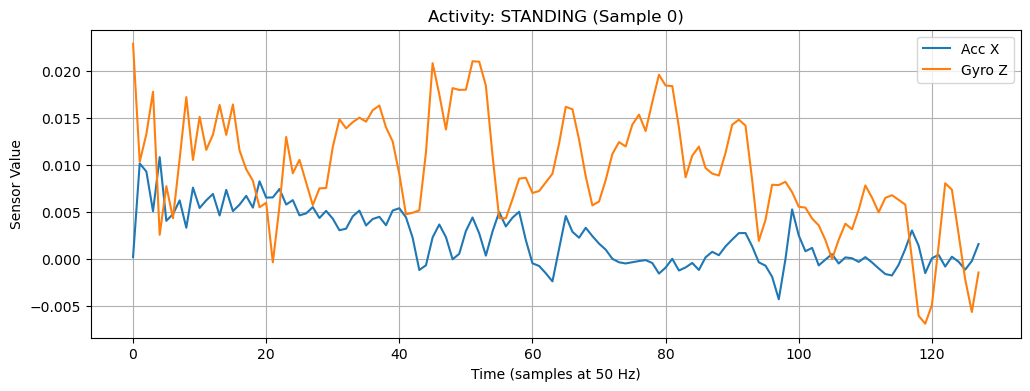

In [34]:
plt.figure(figsize=(12, 4))
plt.plot(signal, label='Acc X')
plt.plot(gyro, label='Gyro Z')
plt.title(f"Activity: {activity_names[label]} (Sample {example_index})")
plt.xlabel("Time (samples at 50 Hz)")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# # Load the dataset
# data = torch.load(f"{DATAFILES_DIR}/raw_handgestures_6channels_filepaths.pt")

# # Extract variables
# train_paths = data["train_paths"]
# train_labels = data["train_labels"]
# test_paths = data["test_paths"]
# test_labels = data["test_labels"]

# Load the pickled dictionary
with open(f"{DATAFILES_DIR}/raw_handgestures_filepaths_segments.pkl", 'rb') as f:
    raw_fileset = pickle.load(f)

# Access the contents
train_paths = raw_fileset["train_segments"]
test_paths = raw_fileset["test_segments"]

print(train_paths)

[('../data-collections/Josh/tonic/standing/variants/Josh62_variants_scale0_6.csv', 236), ('../data-collections/Josh/tremor/laying/variants/Josh140_variants_scale2_3.csv', 236), ('../data-collections/Josh/postural/standing/variants/Josh46_variants_scale4_5.csv', 236), ('../data-collections/Telmen/tonic/falling/variants/Telmen-052925-1_variants_scale2_1.CSV', 237), ('../data-collections/Telmen/tremor/sitting/variants/Telmen12-051425_variants_scale4_2.CSV', 236), ('../data-collections/Telmen/normal/walking/variants/Telmen14-052625_variants_scale2_6.CSV', 236), ('../data-collections/Telmen/postural/standing/variants/Telmen-052925-2_variants_scale3_4.CSV', 237), ('../data-collections/Josh/postural/laying/variants/Josh50_variants_scale3_4.csv', 236), ('../data-collections/Josh/tremor/sitting/variants/Josh89_variants_scale4_8.csv', 236), ('../data-collections/Phillip/normal/walking/variants/DATA3_variants_scale3_3.CSV', 236), ('../data-collections/Telmen/normal/running/variants/Telmen10-05262

Columns in CSV: ['Timestamp(ms)', 'AccelX(g)', 'AccelY(g)', 'AccelZ(g)', 'GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)', 'DistanceLeft(cm)', 'DistanceRight(cm)']
First few rows:
    Timestamp(ms)  AccelX(g)  AccelY(g)  AccelZ(g)  GyroX(deg/s)  GyroY(deg/s)  \
0          22909     -0.023      0.045      1.078        -9.244        -2.503   
1          22959     -0.007      0.026      1.076        -3.809         0.620   
2          23007     -0.009      0.040      1.064        -0.019         4.779   
3          23055     -0.019      0.047      1.075         0.173         1.330   
4          23103      0.004      0.029      1.040        -0.203        -0.909   

   GyroZ(deg/s)  DistanceLeft(cm)  DistanceRight(cm)  
0        -1.875                10                134  
1         1.163                10                134  
2         4.603                 6                135  
3         4.832                 7                135  
4         5.023                 6                135  


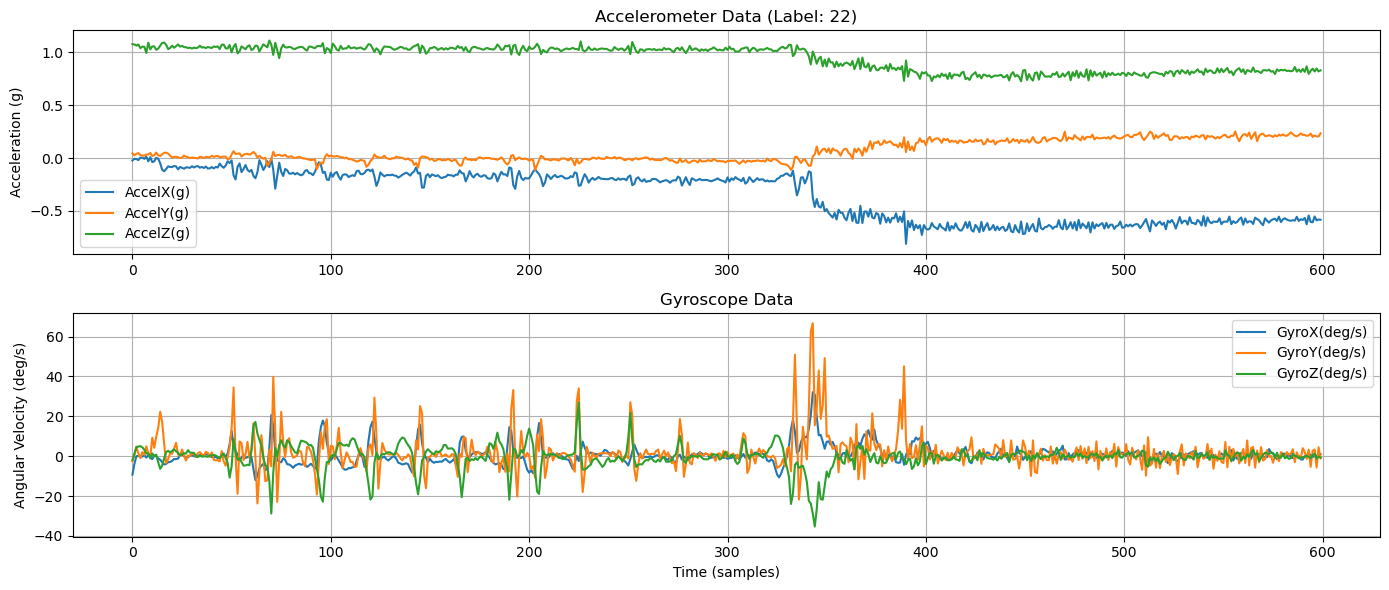

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Invert label_dict if needed (optional, depends on your workflow)
# inv_label_dict = {v: k for k, v in label_dict.items()}

# Pick a sample index to visualize
idx = 0
csv_path = train_paths[idx]
label = train_labels[idx]  # Can be int or string depending on how you saved it

# Load CSV
df = pd.read_csv(csv_path)

# Optional: Print columns to verify
print("Columns in CSV:", df.columns.tolist())
print("First few rows:\n", df.head())

# Assuming your columns include these names:
accel_cols = ['AccelX(g)', 'AccelY(g)', 'AccelZ(g)']
gyro_cols = ['GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']

# Plot
plt.figure(figsize=(14, 6))

# Accelerometer
plt.subplot(2, 1, 1)
for col in accel_cols:
    plt.plot(df[col], label=col)
plt.title(f"Accelerometer Data (Label: {label})")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.grid(True)

# Gyroscope
plt.subplot(2, 1, 2)
for col in gyro_cols:
    plt.plot(df[col], label=col)
plt.title("Gyroscope Data")
plt.ylabel("Angular Velocity (deg/s)")
plt.xlabel("Time (samples)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


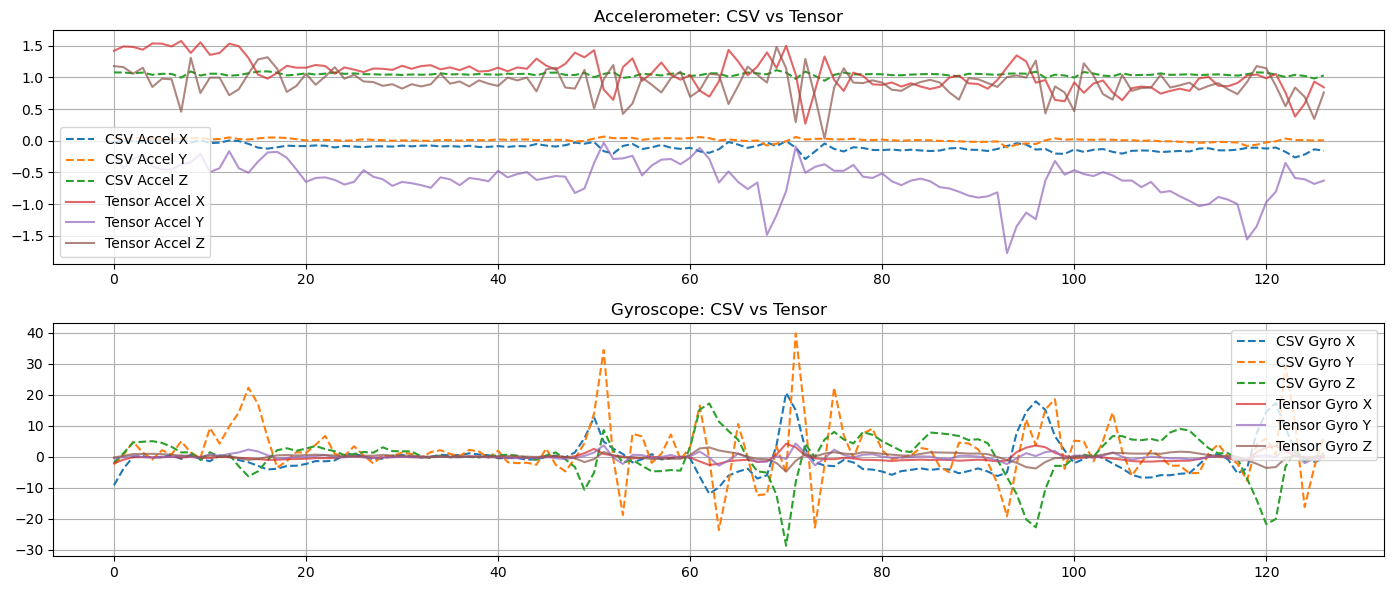

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

# --- Choose index to compare ---
idx = 0
csv_path = train_paths[idx]
tensor_window = train_data[idx]  # Shape: (127, 6)

# --- Load CSV and extract relevant columns ---
df = pd.read_csv(csv_path)
df_values = df[['AccelX(g)', 'AccelY(g)', 'AccelZ(g)','GyroX(deg/s)', 'GyroY(deg/s)', 'GyroZ(deg/s)']].values

# Optional: Trim CSV to 127 rows if it's longer (your model uses windowed slices)
df_values = df_values[:127]

# --- Convert tensor to numpy ---
tensor_values = tensor_window

# --- Plot comparison (overlay) ---
fig, axs = plt.subplots(2, 1, figsize=(14, 6))

# Accelerometer comparison
axs[0].plot(df_values[:, 0], label="CSV Accel X", linestyle="--")
axs[0].plot(df_values[:, 1], label="CSV Accel Y", linestyle="--")
axs[0].plot(df_values[:, 2], label="CSV Accel Z", linestyle="--")

axs[0].plot(tensor_values[:, 0], label="Tensor Accel X", alpha=0.7)
axs[0].plot(tensor_values[:, 1], label="Tensor Accel Y", alpha=0.7)
axs[0].plot(tensor_values[:, 2], label="Tensor Accel Z", alpha=0.7)

axs[0].set_title("Accelerometer: CSV vs Tensor")
axs[0].legend()
axs[0].grid(True)

# Gyroscope comparison
axs[1].plot(df_values[:, 3], label="CSV Gyro X", linestyle="--")
axs[1].plot(df_values[:, 4], label="CSV Gyro Y", linestyle="--")
axs[1].plot(df_values[:, 5], label="CSV Gyro Z", linestyle="--")

axs[1].plot(tensor_values[:, 3], label="Tensor Gyro X", alpha=0.7)
axs[1].plot(tensor_values[:, 4], label="Tensor Gyro Y", alpha=0.7)
axs[1].plot(tensor_values[:, 5], label="Tensor Gyro Z", alpha=0.7)

axs[1].set_title("Gyroscope: CSV vs Tensor")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


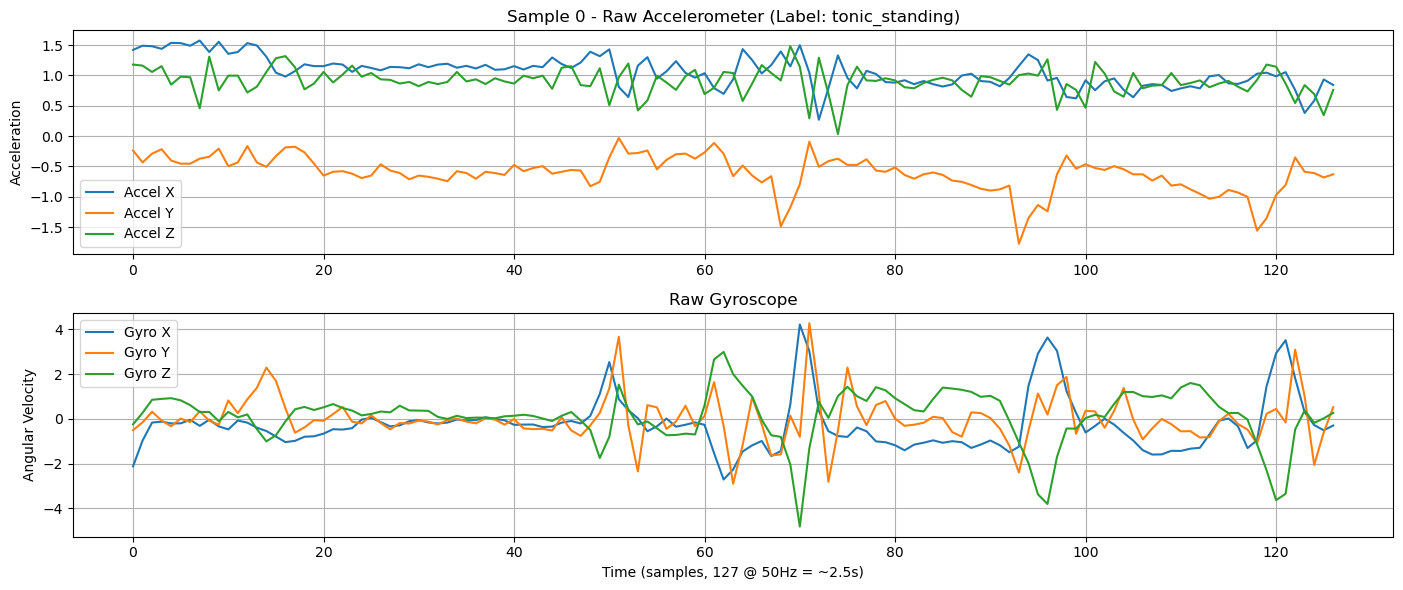

In [37]:
# Reverse label_dict for label decoding
inv_label_dict = {v: k for k, v in label_dict.items()}

# Pick a sample index (e.g., 0, or random)
sample_idx = 0
signal = train_data[sample_idx]               # shape: (127, 6)
label_id = train_labels[sample_idx].item()
label_name = inv_label_dict[label_id]

# Split channels
accel_x = signal[:, 0]
accel_y = signal[:, 1]
accel_z = signal[:, 2]
gyro_x = signal[:, 3]
gyro_y = signal[:, 4]
gyro_z = signal[:, 5]

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(accel_x, label='Accel X')
plt.plot(accel_y, label='Accel Y')
plt.plot(accel_z, label='Accel Z')
plt.title(f"Sample {sample_idx} - Raw Accelerometer (Label: {label_name})")
plt.ylabel("Acceleration")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(gyro_x, label='Gyro X')
plt.plot(gyro_y, label='Gyro Y')
plt.plot(gyro_z, label='Gyro Z')
plt.title("Raw Gyroscope")
plt.ylabel("Angular Velocity")
plt.xlabel("Time (samples, 127 @ 50Hz = ~2.5s)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Load the model

Load the model you want to test out the validation

In [4]:
# In a new script
#model = MPSCNN(num_classes)
# model.load_state_dict(torch.load("handgestures_trained_model_weights_97percent.pt", map_location=device))
# model = MPSCNN_6chan(num_classes)
# model.load_state_dict(torch.load("handgestures_trained_6-channel_model_weights_97percent.pt", map_location=device))

#model = CNNLSTM(input_channels=6, num_classes=num_classes)
#model.load_state_dict(torch.load("Models/handgestures_trained_6-channel_CNN-LSTM_model_weights_99percent.pt", map_location=device))
model = CNNLSTMWithPSD(input_channels=6, psd_dim=psd_vector_dim, num_classes=num_classes)
model.load_state_dict(torch.load("Models/handgestures_trained_6-channel_CNN-LSTM-PSD_model_weights_97percent.pt", map_location=device))

model = CNNLSTMWithAttentionAndGatedFusionAndTCN(input_channels=input_shape[2], psd_dim=psd_vector_dim, num_classes=num_classes)

model.to(device)

NameError: name 'psd_vector_dim' is not defined

## Random Prediction

Pick a random sample from the UCI HAR wavelets and do a prediction

In [32]:
import torch
import numpy as np
import pywt
import random
from scipy.signal import welch

# -- Wavelet Transform Parameters --
scales = range(1, 128)
wavelet = 'morl'

# -- CWT computation --
def compute_cwt(signal_1d, device, scales=scales, wavelet=wavelet):
    signal_np = signal_1d.cpu().numpy() if isinstance(signal_1d, torch.Tensor) else signal_1d
    coeff, _ = pywt.cwt(signal_np, scales, wavelet, 1)
    return torch.from_numpy(coeff[:, :127]).float().to(device)

# -- PSD computation --
def compute_psd(signal_1d, fs=50, nperseg=128):
    """
    Compute PSD from a 1D signal using Welch's method.
    """
    freqs, psd = welch(signal_1d, fs=fs, nperseg=nperseg)
    return psd  # shape: (n_freq_bins,)

# -- Preprocessing for a single sample (CWT only) --
def preprocess_sample(raw_sample, device, expected_channels=6):
    # Normalize each channel (per-sample)
    raw_sample = (raw_sample - raw_sample.mean(axis=0)) / (raw_sample.std(axis=0) + 1e-6)

    channels = []
    for i in range(raw_sample.shape[1]):
        cwt_tensor = compute_cwt(torch.tensor(raw_sample[:, i]), device)
        channels.append(cwt_tensor.unsqueeze(0))  # (1, height, width)

    stacked = torch.cat(channels, dim=0)  # (channels, height, width)

    # Ensure correct number of channels (pad or trim)
    if stacked.shape[0] < expected_channels:
        padding = torch.zeros((expected_channels - stacked.shape[0], 127, 127), device=device)
        stacked = torch.cat([stacked, padding], dim=0)
    elif stacked.shape[0] > expected_channels:
        stacked = stacked[:expected_channels]

    # Add batch and time dimensions
    stacked = stacked.unsqueeze(0).unsqueeze(1)  # (1, 1, C, H, W)

    return stacked

# -- Full prediction with real PSD --
def predict_single_sample(raw_sample, model, device, index_to_label=None):
    # Preprocess CWT
    model_input = preprocess_sample(raw_sample, device, expected_channels=6)  # (1, 1, C, H, W)

    # Compute PSD features
    psd_channels = []
    for i in range(raw_sample.shape[1]):
        psd = compute_psd(raw_sample[:, i])  # (n_freq_bins,)
        psd_channels.append(psd)

    psd_vector = np.concatenate(psd_channels)  # shape: (C * bins,)
    psd_tensor = torch.tensor(psd_vector, dtype=torch.float32, device=device).unsqueeze(0)  # (1, D)

    # Match expected PSD input shape
    expected_psd_dim = model.psd_branch[0].in_features
    if psd_tensor.shape[1] > expected_psd_dim:
        psd_tensor = psd_tensor[:, :expected_psd_dim]
    elif psd_tensor.shape[1] < expected_psd_dim:
        pad = torch.zeros((1, expected_psd_dim - psd_tensor.shape[1]), device=device)
        psd_tensor = torch.cat([psd_tensor, pad], dim=1)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(model_input, psd_tensor)
        prediction = torch.argmax(output, dim=1).item()

    if index_to_label:
        return prediction, index_to_label[prediction]
    return prediction

# -- Random Test Prediction Example --
sample_index = random.randint(0, len(test_data) - 1)
sample = test_data[sample_index]
#true_label_int = test_labels[sample_index] + 1  # shift if 1-based
true_label_int = test_labels[sample_index]
true_label_name = activity_labels.get(true_label_int, "Unknown")

# Predict
predicted_index, predicted_name = predict_single_sample(sample, model, device, index_to_label=index_to_label)
predicted_label = next(k for k, v in label_dict.items() if v == predicted_index)

# Output
print(f"\nSample index: {sample_index}")
print(f"True label int: {true_label_int}")
print(f"True label name: {true_label_name}")
print(f"Predicted label index: {predicted_index}")
print(f"Predicted label name: {predicted_label}")


Sample index: 526
True label int: 4
True label name: SITTING
Predicted label index: 9
Predicted label name: postural_standing


In [28]:
import numpy as np
import torch
from scipy.signal import welch

def normalize_sample(sample):
    """
    Normalize each channel in a sample (127, C) to zero mean and unit variance.
    Returns: normalized sample of shape (127, C)
    """
    mean = np.mean(sample, axis=0, keepdims=True)
    std = np.std(sample, axis=0, keepdims=True)
    std[std == 0] = 1e-6  # Prevent division by zero
    return (sample - mean) / std

def compute_psd(signal_1d, fs=50, nperseg=128):
    """
    Compute PSD from a 1D signal using Welch's method.
    """
    freqs, psd = welch(signal_1d, fs=fs, nperseg=nperseg)
    return psd

def preprocess_batch(raw_batch, device, expected_channels=6):
    """
    raw_batch: numpy array (batch_size, 127, C)
    Returns: torch tensor (batch_size, 1, expected_channels, 127, 127)
    """
    batch_size = raw_batch.shape[0]
    processed = []
    for i in range(batch_size):
        norm_sample = normalize_sample(raw_batch[i])  # shape (127, C)
        sample_tensor = preprocess_sample(norm_sample, device, expected_channels)  # shape (1,1,C,H,W)
        processed.append(sample_tensor)
    return torch.cat(processed, dim=0)  # (batch_size, 1, expected_channels, 127, 127)

def compute_batch_psd(raw_batch):
    """
    raw_batch: numpy array (batch_size, 127, C)
    Returns: torch tensor (batch_size, PSD_feature_dim)
    """
    batch_psd = []
    for sample in raw_batch:
        psd_channels = []
        for c in range(sample.shape[1]):
            psd = compute_psd(sample[:, c])  # shape (n_freq_bins,)
            psd_channels.append(psd)
        psd_vector = np.concatenate(psd_channels)  # (C * n_freq_bins,)
        batch_psd.append(psd_vector)
    batch_psd = np.stack(batch_psd)  # (batch_size, PSD_feature_dim)
    return torch.tensor(batch_psd, dtype=torch.float32)

def predict_batch(raw_batch, raw_labels, model, device, index_to_label=None, label_dict=None):
    """
    raw_batch: numpy array (batch_size, 127, C)
    raw_labels: numpy array or list of true label indices (batch_size,)
    """
    model_input = preprocess_batch(raw_batch, device, expected_channels=6)  # (B, 1, C, 127, 127)
    batch_size = model_input.shape[0]

    # Compute PSD features for batch
    psd_tensor = compute_batch_psd(raw_batch).to(device)  # (B, PSD_feature_dim)

    # Match expected PSD input dimension
    expected_psd_dim = model.psd_branch[0].in_features
    if psd_tensor.shape[1] > expected_psd_dim:
        psd_tensor = psd_tensor[:, :expected_psd_dim]
    elif psd_tensor.shape[1] < expected_psd_dim:
        pad = torch.zeros((batch_size, expected_psd_dim - psd_tensor.shape[1]), device=device)
        psd_tensor = torch.cat([psd_tensor, pad], dim=1)

    model.eval()
    with torch.no_grad():
        outputs = model(model_input.to(device), psd_tensor)  # (batch_size, num_classes)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

    # Reverse label index to name if provided
    pred_names = None
    if index_to_label:
        index_to_label_inv = {v: k for k, v in index_to_label.items()}
        pred_names = [index_to_label_inv.get(p, "Unknown") for p in preds]

    true_names = None
    if label_dict is not None and raw_labels is not None:
        true_names = [label_dict.get(lbl, "Unknown") for lbl in raw_labels]

    return preds, pred_names, raw_labels, true_names


# --- Usage example with random batch ---
batch_size = 10
total_samples = len(test_data)

random_indices = np.random.choice(total_samples, size=batch_size, replace=False)
batch_samples = test_data[random_indices]   # shape (10, 127, C)
batch_labels = test_labels[random_indices]   # shape (10,)

predicted_indices, predicted_labels, true_indices, true_labels = predict_batch(
    batch_samples, batch_labels, model, device,
    index_to_label=label_dict,   # label index->name map
    label_dict=activity_labels   # int label->human name map
)

print("Random Indices:", random_indices)
print("Predicted indices:", predicted_indices)
print("Predicted labels:", predicted_labels)
print("True indices:", true_indices)
print("True labels:", true_labels)

Random Indices: [ 344 1947 1976 2025 2064  129 1353  356 1218  911]
Predicted indices: [ 9  9  9 22  9 22 10 22 22  9]
Predicted labels: ['postural_standing', 'postural_standing', 'postural_standing', 'tonic_standing', 'postural_standing', 'tonic_standing', 'postural_sitting', 'tonic_standing', 'tonic_standing', 'postural_standing']
True indices: [1 6 5 2 6 6 5 4 5 2]
True labels: ['WALKING', 'LAYING', 'STANDING', 'WALKING_UPSTAIRS', 'LAYING', 'LAYING', 'STANDING', 'SITTING', 'STANDING', 'WALKING_UPSTAIRS']


In [29]:
from sklearn.metrics import classification_report

def print_precision_recall(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Per-Class Precision, Recall, and F1:")
    print(report)

# Assuming you have predictions
y_true = y_test_seq_last.cpu().numpy()
y_pred = model(x_test_seq.to(device), psd_test_seq_padded.to(device)).argmax(dim=1).cpu().numpy()

# Class names
class_names = ['normal', 'tonic', 'tremor', 'postural']  # <- customize as needed

#plot_confusion_matrix(y_true, y_pred, class_names)
print_precision_recall(y_true, y_pred, class_names)

RuntimeError: MPS backend out of memory (MPS allocated: 12.79 GB, other allocations: 3.33 MB, max allowed: 21.33 GB). Tried to allocate 10.38 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

# Visualizations

Insights that were gathered from the data training and validation work

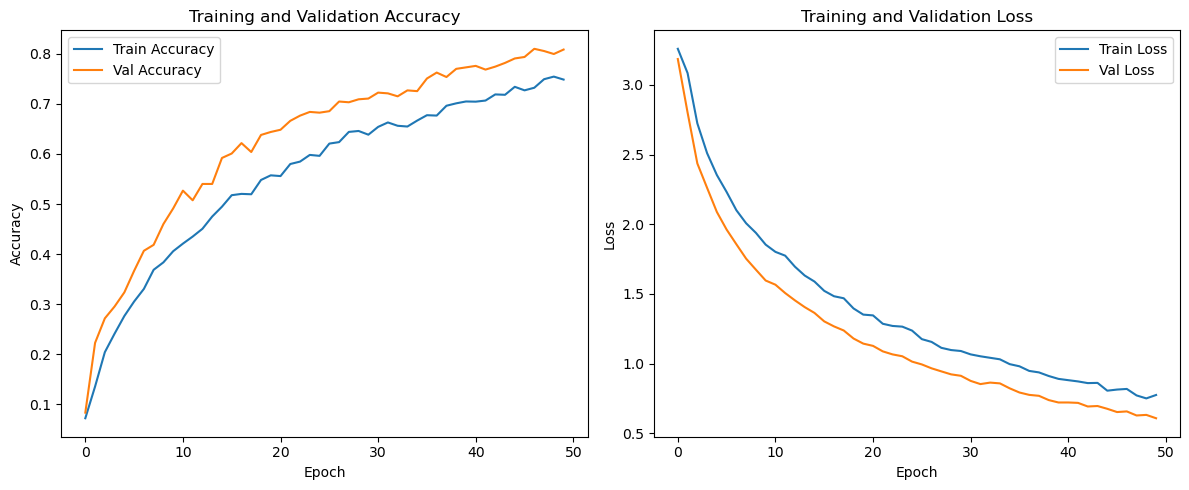

In [36]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


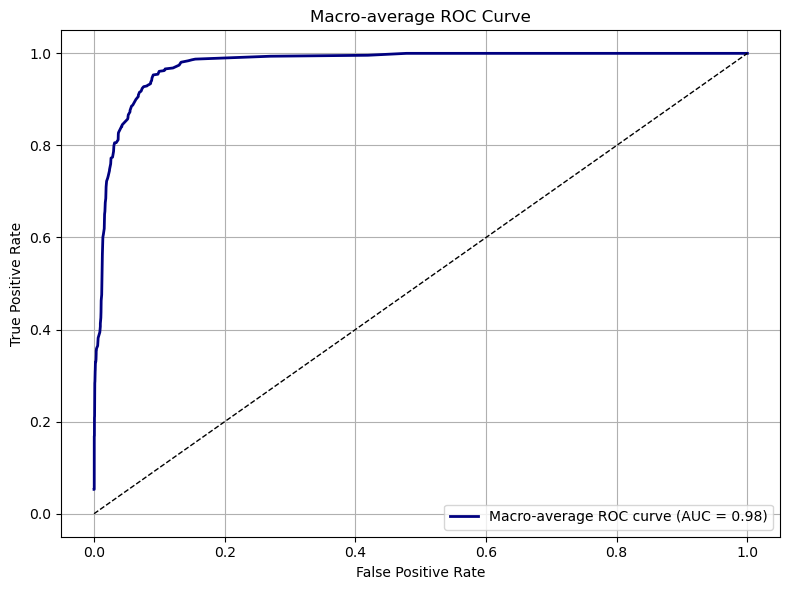

In [10]:
def compute_roc_auc(model, loader, n_classes):
    all_labels = []
    all_probs = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())
            torch.mps.empty_cache()

    y_true = np.concatenate(all_labels)
    y_score = np.concatenate(all_probs)

    # One-hot encode the labels
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro-average ROC curve and AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    return fpr, tpr, roc_auc

# Compute and plot ROC-AUC
fpr, tpr, roc_auc = compute_roc_auc(model, test_loader, num_classes)

plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', color='navy', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
unique_classes = np.unique(y_train)  # or use y_train_tensor.cpu().numpy()
print(unique_classes)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97]


In [15]:
class_to_index = {cls: idx for idx, cls in enumerate(sorted(unique_classes))}
print(class_to_index)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97}
